# Smoothers and Generalized Additive Models

Michel Kana

<hr style="height:2pt">

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.formula.api as sm
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from sklearn.preprocessing import PolynomialFeatures
r_utils = importr('utils')
# if there are errors about missing R packages, uncomment and run the lines below:
#r_utils.install_packages('codetools')
#r_utils.install_packages('gam')
r_splines = importr('splines')
r_smooth_spline = robjects.r['smooth.spline'] #extract R function
r_gam_lib = importr('gam')
r_gam = r_gam_lib.gam #extract R function
r_glm = robjects.r['glm'] #extract R function
r_anova = robjects.r['anova'] #extract R function

In [2]:
from sklearn.metrics import r2_score
from pandas.plotting import scatter_matrix
%load_ext rpy2.ipython


<hr style="height:2pt">

### Part 1 - Modeling Seasonality of Airbnb Prices
In this project, the task is to build a regression model to predict the price of an Airbnb rental for a given date. The data are provided in `calendar_train.csv` and `calendar_test.csv`, which contain availability and price data for Airbnb units in the Boston area from 2017 to 2018. Note that some of the rows in the `.csv` file refer to dates in the future. These refer to bookings that have been made far in advance.

Start by loading the data using pandas:

In [4]:
df_train = pd.read_csv('data/calendar_train.csv')
df_test = pd.read_csv('data/calendar_test.csv')

In [5]:
print('Train dataset has {} rows and {} columns'.format(df_train.shape[0], df_train.shape[1]))
print('Test dataset has {} rows and {} columns'.format(df_test.shape[0], df_test.shape[1]))

Train dataset has 734003 rows and 4 columns
Test dataset has 314572 rows and 4 columns


In [6]:
df_train.head()

,listing_id,date,available,price
0,20872145,9/21/18,f,NaN
1,20872145,9/19/18,f,NaN
2,20872145,9/18/18,f,NaN
3,20872145,9/17/18,f,NaN
4,20872145,9/16/18,f,NaN


In [7]:
df_train.describe()

,listing_id,price
count,7.340030e+05,309288.000000
mean,1.253864e+07,238.780612
std,6.334971e+06,188.527983
min,3.781000e+03,15.000000
25%,7.281884e+06,115.000000
50%,1.390864e+07,190.000000
75%,1.835457e+07,299.000000
max,2.122836e+07,5993.000000


In [8]:
df_test.describe()

,listing_id,price
count,3.145720e+05,133100.000000
mean,1.253792e+07,239.744733
std,6.333996e+06,192.059271
min,3.781000e+03,15.000000
25%,7.281884e+06,115.000000
50%,1.390803e+07,190.000000
75%,1.835689e+07,300.000000
max,2.122836e+07,10000.000000


In [9]:
df_train.dtypes

listing_id      int64
date           object
available      object
price         float64
dtype: object

In [10]:
df_train.available.unique()

array(['f', 't'], dtype=object)

In [11]:
df_train[(df_train.available=='f') & (~ df_train.price.isnull())]

,listing_id,date,available,price


In [12]:
df_train[(df_train.available=='t') & (df_train.price.isnull())]

,listing_id,date,available,price


In [13]:
df_train.groupby(['listing_id']).count().head()

,date,available,price
listing_id,,,
3781,267,267,153
5506,261,261,245
6695,272,272,241
6976,248,248,47
8792,265,265,208


Each row describes a booking made on a `listing_id`, at a `date`. If the booking was made far in advance, then `available` has the value `f` and the `price` is empty (unknown). Otherwise `available` is `t` and the `price` is given.

### Exploratory Analysis

Visualize the average price by month and day of the week (i.e., Monday, Tuesday, etc.) for the training set. Point out any trends we notice and explain whether or not they make sense.


In [14]:
df_train_2 = df_train[~ df_train.price.isnull()].copy()
df_train_2.date = pd.to_datetime(df_train_2.date, format='%m/%d/%y')
df_train_2['month'] = df_train_2.date.dt.month
df_train_2['month_name'] = df_train_2.date.dt.month_name()
df_train_2['weekday'] = df_train_2.date.dt.weekday
df_train_2['weekday_name'] = df_train_2.date.dt.day_name()

In [15]:
df_train_2.head()

,listing_id,date,available,price,month,month_name,weekday,weekday_name
123,20872145,2018-04-02,t,62.0,4,April,0,Monday
124,20872145,2018-04-01,t,59.0,4,April,6,Sunday
125,20872145,2018-03-31,t,75.0,3,March,5,Saturday
126,20872145,2018-03-30,t,71.0,3,March,4,Friday
127,20872145,2018-03-28,t,51.0,3,March,2,Wednesday


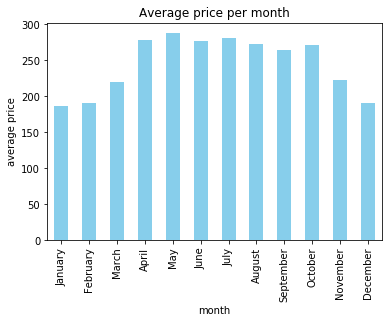

In [16]:
ax = df_train_2.groupby(['month','month_name']) \
                    .agg({'price': np.mean}).reset_index() \
                    .sort_values(by=['month']).plot.bar(x='month_name', y='price', color='skyblue', title='Average price per month')
ax.set_xlabel('month')
ax.set_ylabel('average price')
ax.legend().set_visible(False);

Average booking price is the highest between April and October, and lowest between November and February. High prices duirng summer time is expected. But low prices in December (Christmas) is surprising.

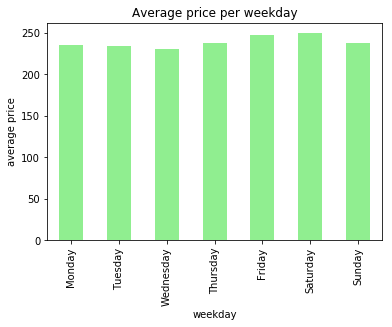

In [17]:
ax = df_train_2.groupby(['weekday','weekday_name']) \
                    .agg({'price': np.mean}).reset_index() \
                    .sort_values(by=['weekday']).plot.bar(x='weekday_name', y='price', color='lightgreen', title='Average price per weekday')
ax.set_xlabel('weekday')
ax.set_ylabel('average price')
ax.legend().set_visible(False);

Friday and Saturday are the most expensive week days for booking. These are weekend bookings. The remaining days are on average the same price.

### Explore different regression models

Fit a regression model that uses the date as a predictor and predicts the average price of an Airbnb rental on that date. For this part of the question, we can ignore all other predictors besides the date. Fit the following models on the training set, and compare the $R^2$ of the fitted models on the test set. Include plots of the fitted models for each method.

1. Regression models with different basis functions:
    * Simple polynomials with degrees 5, 25, and 50
    * Cubic B-splines with the knots chosen by visual inspection of the data
    * Natural cubic splines with the degree of freedom chosen by cross-validation on the training set.
    
2. Smoothing spline model with the smoothness parameter chosen by cross-validation on the training set.

In each case, analyze the effect of the relevant tuning parameters on the training and test $R^2$ and give explanations for what we observe.

Is there a reason we would prefer one of these methods over the other?


**Preparing the data**

We convert the date into a numerical variable. We consider the average price for each date.

In [18]:
df_train_summary = df_train_2.groupby(['date']) \
                    .agg({'price': np.mean}).reset_index()
min_date = df_train_summary.date.min()
df_train_summary.date = df_train_summary.date - min_date
df_train_summary.date = df_train_summary.date.dt.days
df_train_summary.sample(frac=.01)

,date,price
42,42,269.131188
362,362,236.257967
345,345,258.733154
320,320,266.929708


In [19]:
df_test_2 = df_test[~ df_test.price.isnull()].copy()
df_test_2.date = pd.to_datetime(df_test_2.date, format='%m/%d/%y')
df_test_2['month'] = df_test_2.date.dt.month
df_test_2['month_name'] = df_test_2.date.dt.month_name()
df_test_2['weekday'] = df_test_2.date.dt.weekday
df_test_2['weekday_name'] = df_test_2.date.dt.day_name()
df_test_summary = df_test_2.groupby(['date']) \
                    .agg({'price': np.mean}).reset_index()
df_test_summary.date = df_test_summary.date - min_date
df_test_summary.date = df_test_summary.date.dt.days
df_test_summary.sample(frac=.01)

,date,price
358,358,274.664653
207,207,264.774194
52,52,199.392377
120,120,203.591928


**Simple polynomials**

In [20]:
r_predict = robjects.r["predict"]
r_lm = robjects.r["lm"]
df_r2_scores = pd.DataFrame({'R2':[]})

In [21]:
# function that fits a linear model on training dataset, plots the regression line and report the R2 on test
# The 'order' parameter can be specified to add higher order polynomial terms
def fit_polynomial(order, df_train_summary=df_train_summary, df_test_summary=df_test_summary, title='model'):
    r_date_train = robjects.FloatVector(df_train_summary.date) 
    r_price_train = robjects.FloatVector(df_train_summary.price)
    bookings_train_r = robjects.DataFrame({'date': r_date_train, 'price': r_price_train})

    simple_formula = robjects.Formula("price ~ poly(date, {}, raw=TRUE)".format(order))
    bookings_lm = r_lm(formula=simple_formula, data=bookings_train_r)
    predict_df = robjects.DataFrame({'date': robjects.FloatVector(np.linspace(0, 364, 100))})
    predictions = r_predict(bookings_lm, predict_df)
    fig, ax = plt.subplots(1,2,figsize=(15,5))
    df_train_summary.plot.scatter(x='date',y='price',c='Red',title="{} - Bookings train data".format(title), ax=ax[0])
    ax[0].set_xlabel("date")
    ax[0].set_ylabel("price");
    ax[0].plot(predict_df.rx2("date"),predictions);
    
    predict_test_df = robjects.DataFrame({'date': robjects.FloatVector(df_test_summary.date)})
    predictions_test = r_predict(bookings_lm, predict_test_df)
    df_test_summary.plot.scatter(x='date',y='price',c='Green',title="{} - Bookings test data".format(title), ax=ax[1])
    ax[1].set_xlabel("date")
    ax[1].set_ylabel("price");
    ax[1].plot(predict_test_df.rx2("date"),predictions_test);
    
    r2 = r2_score(df_test_summary.price, predictions_test)
    print(title)    
    print("R2 on test: {}".format(r2))
    df_r2_scores.loc[title] = r2

5-order Polynomial
R2 on test: 0.6850169815923071


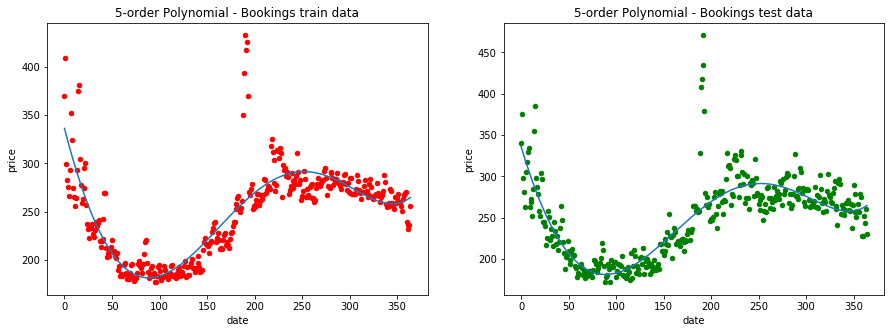

In [22]:
fit_polynomial(5, title='5-order Polynomial')

25-order Polynomial
R2 on test: 0.7256175978415551


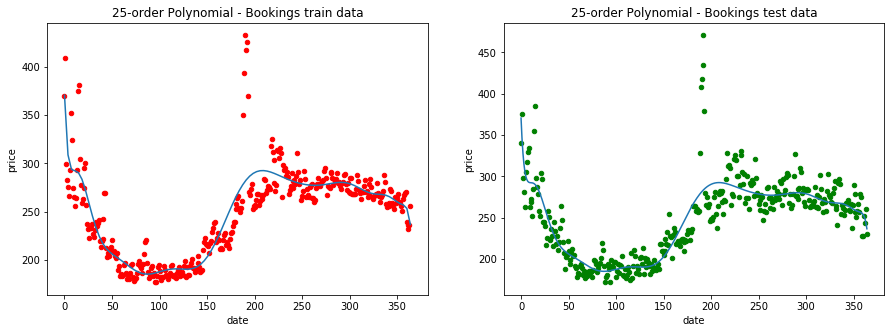

In [23]:
fit_polynomial(25, title='25-order Polynomial')

50-order Polynomial
R2 on test: 0.7403423978368684


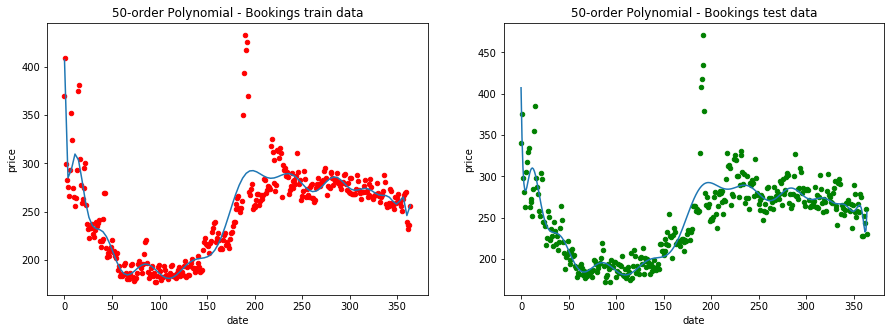

In [24]:
fit_polynomial(50, title='50-order Polynomial')

Looking at the blue line fit to training data, we can observe increasing curving with increasing polynomial order. This is due to increased model complexity, since the higher order polynomials try to chase each single data point in the training set. Especially at regions with outliers (beginning and middle parts of the plot), higher degree polynomials tend to go in the direction of those outliers. As consequence, the model with 50 order polynomials has highest variance. It also has the lowest biais on train, which is reflected by the highest R2 score, compared to lower order polynomials, which have lower R2, meaning higher biais, but lower variance. Lower order polynomials are less sensitive to training data. 

In [25]:
df_r2_scores

,R2
5-order Polynomial,0.685017
25-order Polynomial,0.725618
50-order Polynomial,0.740342


**Cubic B-splines with the knots chosen by visual inspection of the data**

In [26]:
# function that fits a cubic B-spline on training dataset, plots the regression line and report the R2 on test
# The 'knots' parameter can be specified as a list of knots
def fit_b_spline(knots=np.quantile(df_train_summary.date,[.25,.5,.75]), df_train_summary=df_train_summary, df_test_summary=df_test_summary, title='model'):
    r_date_train = robjects.FloatVector(df_train_summary.date) 
    r_price_train = robjects.FloatVector(df_train_summary.price)

    r_quarts = robjects.FloatVector(knots)
    bs_design = r_splines.bs(r_date_train, knots=r_quarts)
    
    bs_formula = robjects.Formula("price ~ bs(date, knots=r_quarts) + bs(date**2, knots=r_quarts) + bs(date**3, knots=r_quarts)")
    bs_formula.environment['price'] = r_price_train
    bs_formula.environment['date'] = r_date_train
    bs_formula.environment['r_quarts'] = r_quarts

    bs_model = r_lm(bs_formula)
    predict_df = robjects.DataFrame({'date': robjects.FloatVector(np.linspace(0, 364, 100))})
    bs_out = r_predict(bs_model, predict_df)

    fig, ax = plt.subplots(1,2,figsize=(15,5))
    df_train_summary.plot.scatter(x='date',y='price',c='Red',title="{} - Bookings train data".format(title), ax=ax[0])
    ax[0].set_xlabel("date")
    ax[0].set_ylabel("price");
    ax[0].plot(predict_df.rx2("date"),bs_out);
    
    predict_test_df = robjects.DataFrame({'date': robjects.FloatVector(df_test_summary.date)})
    bs_out_test = r_predict(bs_model, predict_test_df)
    df_test_summary.plot.scatter(x='date',y='price',c='Green',title="{} - Bookings test data".format(title), ax=ax[1])
    ax[1].set_xlabel("date")
    ax[1].set_ylabel("price");
    ax[1].plot(predict_test_df.rx2("date"),bs_out_test);
    
    r2 = r2_score(df_test_summary.price, bs_out_test)
    print(title)    
    print("R2 on test: {}".format(r2))
    df_r2_scores.loc[title] = r2

Cubic B-spline, knots at quartiles
R2 on test: 0.7312214291229109


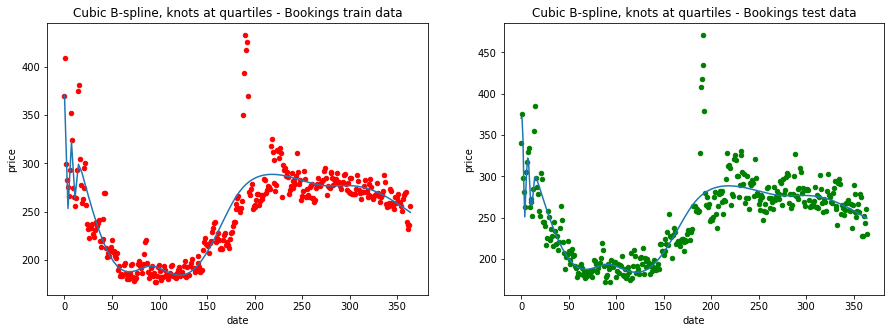

In [27]:
fit_b_spline(title='Cubic B-spline, knots at quartiles')

Cubic B-spline, knots manually chosen
R2 on test: 0.747073906231448


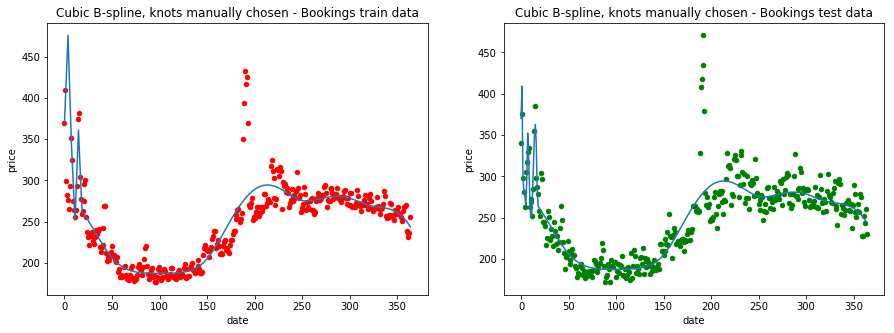

In [28]:
fit_b_spline(knots=[50, 100,150,250,300, 320], title='Cubic B-spline, knots manually chosen')

With splines, we split the data in chunks and fit a basis function to each chunk. Each basis function is connected to the next one at the knots. Cubic polynomials are a very good choice because the connections are smooths; their slope, 1st and 2nd derivative match, and the order 3 is still small enough to avoid variability.

B-splines are an easier variant for efficient computation because at most five basis functions are involved in contributing
towards any function value. 

By choosing the knots manually, i.e. where we have bunch of data points (around 100 and 250) we achieve better R2 on test, compared to the score when knots are placed based on percentiles. 

In [29]:
df_r2_scores

,R2
5-order Polynomial,0.685017
25-order Polynomial,0.725618
50-order Polynomial,0.740342
"Cubic B-spline, knots at quartiles",0.731221
"Cubic B-spline, knots manually chosen",0.747074


**Natural cubic splines with the degree of freedom chosen by cross-validation on the training set.**

In [30]:
# function that fits a cubic Natural-spline on training dataset, plots the regression line and report the R2 on test
# the degree of freedom is calculated via CV
def fit_n_spline(df_train_summary=df_train_summary, df_test_summary=df_test_summary, title='model'):
    r_date_train = robjects.FloatVector(df_train_summary.date) 
    r_price_train = robjects.FloatVector(df_train_summary.price)
    
    spline_cv = r_smooth_spline(x=r_date_train, y=r_price_train, cv=True, tol=1/1000000)    
    df_cv = int(spline_cv.rx2("df")[0])

    ns_design = r_splines.ns(r_date_train, df=df_cv)
    
    ns_formula = robjects.Formula("price ~ bs(date) + bs(date**2) + bs(date**3)")
    ns_formula.environment['price'] = r_price_train
    ns_formula.environment['date'] = r_date_train

    ns_model = r_lm(ns_formula)
    predict_df = robjects.DataFrame({'date': robjects.FloatVector(np.linspace(0, 364, 100))})
    ns_out = r_predict(ns_model, predict_df)

    fig, ax = plt.subplots(1,2,figsize=(15,5))
    df_train_summary.plot.scatter(x='date',y='price',c='Red',title="{} - Bookings train data".format(title), ax=ax[0])
    ax[0].set_xlabel("date")
    ax[0].set_ylabel("price");
    ax[0].plot(predict_df.rx2("date"),ns_out);
    
    predict_test_df = robjects.DataFrame({'date': robjects.FloatVector(df_test_summary.date)})
    ns_out_test = r_predict(ns_model, predict_test_df)
    df_test_summary.plot.scatter(x='date',y='price',c='Green',title="{} - Bookings test data".format(title), ax=ax[1])
    ax[1].set_xlabel("date")
    ax[1].set_ylabel("price");
    ax[1].plot(predict_test_df.rx2("date"),ns_out_test);
    
    r2 = r2_score(df_test_summary.price, ns_out_test)
    print(title + " - degree of freedom via cross-validation: " + str(df_cv))
    print("R2 on test: {}".format(r2))
    df_r2_scores.loc[title] = r2

Cubic Natural-spline with degree of freedom via CV - degree of freedom via cross-validation: 97
R2 on test: 0.697681594146291


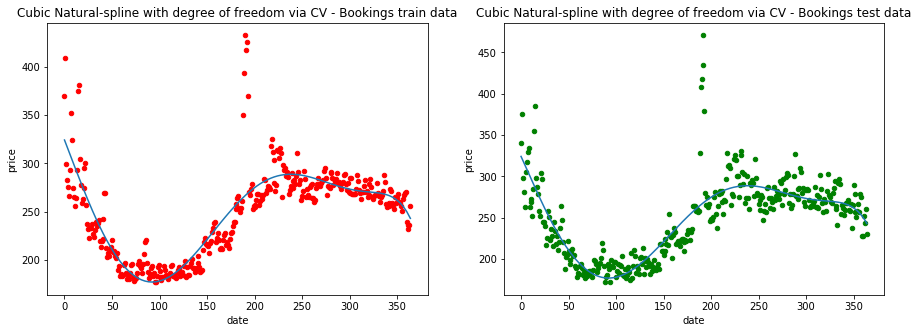

In [31]:
fit_n_spline(title='Cubic Natural-spline with degree of freedom via CV')

Cubic splines near boundaries can behave strangely. The natural cubic splines enforce that the function is linear outside the extreme knots, by changing a cubic polynomial to linear at each extreme. The degree of freedom is found via cross-validation. 96 knots are suitably chosen quantiles of date. Result is less variability at the edges, but slightly worse R2 on test compared to cubic B-spline.

In [32]:
df_r2_scores

,R2
5-order Polynomial,0.685017
25-order Polynomial,0.725618
50-order Polynomial,0.740342
"Cubic B-spline, knots at quartiles",0.731221
"Cubic B-spline, knots manually chosen",0.747074
Cubic Natural-spline with degree of freedom via CV,0.697682


**Smoothing spline model with the smoothness parameter chosen by cross-validation on the training set.**

In [33]:
# function that fits a smoother spline on training dataset, plots the regression line and report the R2 on test
# the penalty lambda is calculated via CV
def fit_smoothing_spline(df_train_summary=df_train_summary, df_test_summary=df_test_summary, title='model'):
    r_date_train = robjects.FloatVector(df_train_summary.date) 
    r_price_train = robjects.FloatVector(df_train_summary.price)
    
    spline_cv = r_smooth_spline(x=r_date_train, y=r_price_train, cv=True, tol=1/1000000)    
    lambda_cv = spline_cv.rx2("lambda")[0]

    fig, ax = plt.subplots(1,2,figsize=(15,5))
    df_train_summary.plot.scatter(x='date',y='price',c='Red',title="{} - Bookings train data".format(title), ax=ax[0])
    ax[0].set_xlabel("date")
    ax[0].set_ylabel("price");
    ax[0].plot(spline_cv.rx2("x"),spline_cv.rx2("y"));
    
    predict_test_df = robjects.DataFrame({'date': robjects.FloatVector(df_test_summary.date)})
    predictions = r_predict(spline_cv, predict_test_df)
    df_test_summary.plot.scatter(x='date',y='price',c='Green',title="{} - Bookings test data".format(title), ax=ax[1])
    ax[1].set_xlabel("date")
    ax[1].set_ylabel("price");
    ax[1].plot(df_test_summary.date,np.array(predictions.rx2("y")).ravel());
    
    r2 = r2_score(df_test_summary.price, np.array(predictions.rx2("y")).ravel())
    print(title + " - lambda found via cross-validation: " + str(lambda_cv))
    print("R2 on test: {}".format(r2))
    df_r2_scores.loc[title] = r2

Smoothing spline - lambda found via cross-validation: 1.904807804135032e-08
R2 on test: 0.9093366914054126


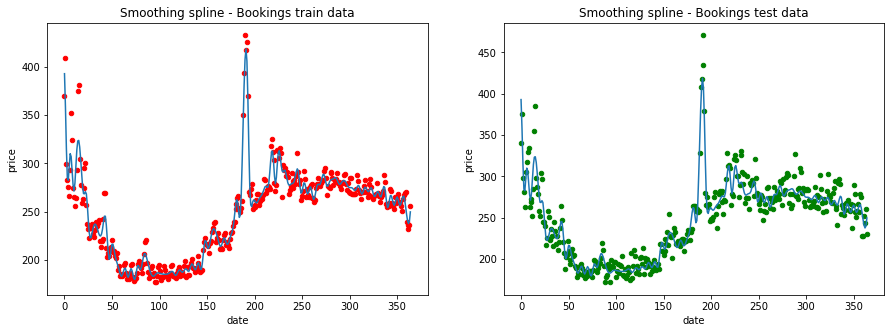

In [34]:
fit_smoothing_spline(title='Smoothing spline')

We found smoothing splines which minimize the MSE while penalyzing variations in response. The solution is a cubic spline which achieves the best R2 score so far on test.

Between all models investigated so far, we would choose a smoothing spline model for the price prediction task.

In [35]:
df_r2_scores

,R2
5-order Polynomial,0.685017
25-order Polynomial,0.725618
50-order Polynomial,0.740342
"Cubic B-spline, knots at quartiles",0.731221
"Cubic B-spline, knots manually chosen",0.747074
Cubic Natural-spline with degree of freedom via CV,0.697682
Smoothing spline,0.909337


### Part 1b: Adapting to weekends

Does the pattern of Airbnb pricing differ over the days of the week? Are the patterns on weekends different from those on weekdays? If so, we might benefit from using a different regression model for weekdays and weekends. Split the training and test data into two parts, one for weekdays and one for weekends, and fit a separate model for each training subset. Do the models yield a higher $R^2$ on the corresponding test subsets compared to the model fitted previously?

As shown during exploratory analysis, the average price increases from Monday when moving towards the weekend. Between Saturday and Sunday prices tend to decrease. This opposite trend suggests to split the data as follows.

**Weekdays**

We consider bookings made on Sun, Mo, Tue, Wed, Thu.

In [36]:
df_train_summary_weekday = df_train_2[df_train_2.weekday.isin([0,1,2,3,6])].groupby(['date']) \
                    .agg({'price': np.mean}).reset_index()
df_train_summary_weekday.date = df_train_summary_weekday.date - min_date
df_train_summary_weekday.date = df_train_summary_weekday.date.dt.days
df_train_summary_weekday.sample(frac=.01)

,date,price
97,137,187.777992
2,4,275.933202
29,41,242.607456


In [37]:
df_test_summary_weekday = df_test_2[df_test_2.weekday.isin([0,1,2,3,6])].groupby(['date']) \
                    .agg({'price': np.mean}).reset_index()
df_test_summary_weekday.date = df_test_summary_weekday.date - min_date
df_test_summary_weekday.date = df_test_summary_weekday.date.dt.days
df_test_summary_weekday.sample(frac=.01)

,date,price
181,255,247.795918
78,110,176.966960
134,188,327.729560


5-order Polynomial Weekdays
R2 on test: 0.7099906266511862
25-order Polynomial Weekdays
R2 on test: 0.7462118623591292
50-order Polynomial Weekdays
R2 on test: 0.7594275209160325


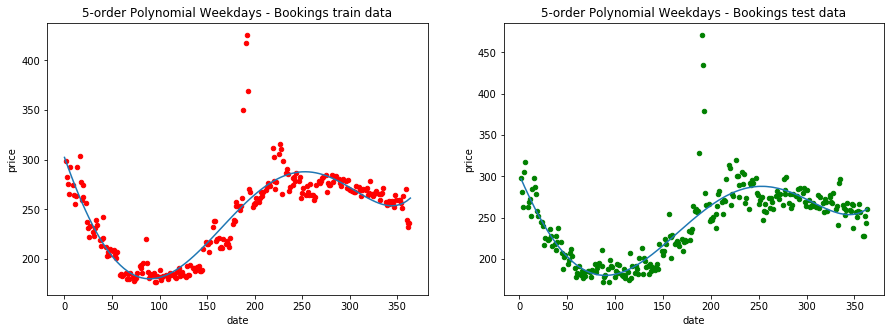

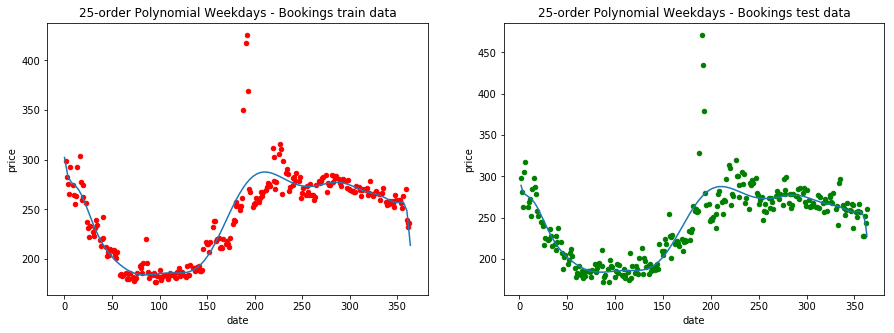

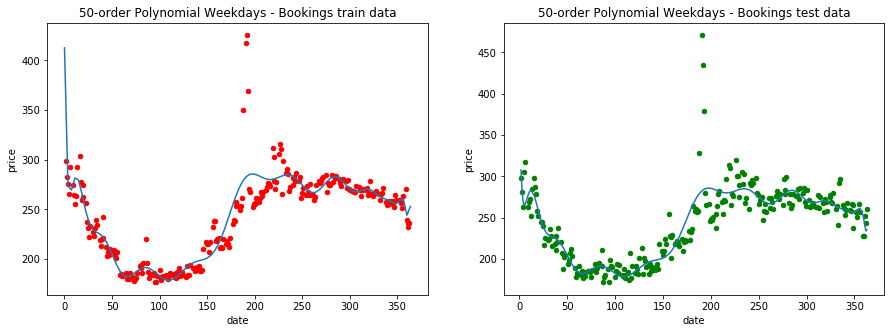

In [38]:
for order in [5, 25, 50]:
    fit_polynomial(order, df_train_summary_weekday, df_test_summary_weekday, title='{}-order Polynomial Weekdays'.format(order))

**Weekends**

We consider bookings made on Fri and Sat.

In [39]:
df_train_summary_weekend = df_train_2[df_train_2.weekday.isin([4,5])].groupby(['date']) \
                    .agg({'price': np.mean}).reset_index()
df_train_summary_weekend.date = df_train_summary_weekend.date - min_date
df_train_summary_weekend.date = df_train_summary_weekend.date.dt.days
df_train_summary_weekend.sample(frac=.05)

,date,price
33,113,194.378378
12,42,269.131188
28,98,193.003749
50,175,228.012948
75,260,278.508366


In [40]:
df_test_summary_weekend = df_train_2[df_train_2.weekday.isin([4,5])].groupby(['date']) \
                    .agg({'price': np.mean}).reset_index()
df_test_summary_weekend.date = df_test_summary_weekend.date - min_date
df_test_summary_weekend.date = df_test_summary_weekend.date.dt.days
df_test_summary_weekend.sample(frac=.05)

,date,price
18,63,194.660633
98,343,273.033245
1,1,409.298701
84,294,287.553846
24,84,205.527679


5-order Polynomial Weekend
R2 on test: 0.7621855542505042
25-order Polynomial Weekend
R2 on test: 0.8091314458439901
50-order Polynomial Weekend
R2 on test: 0.8314899226013789


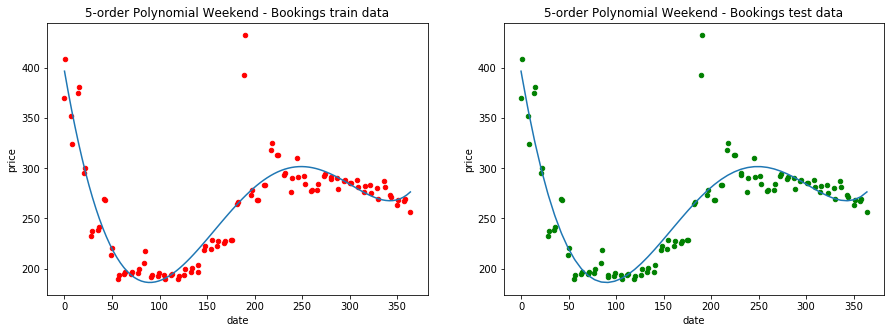

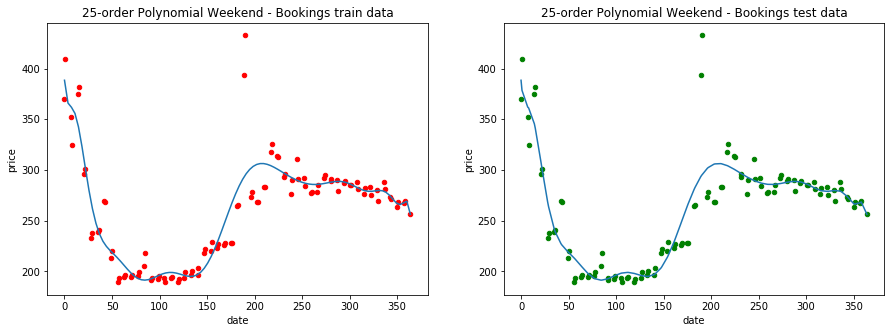

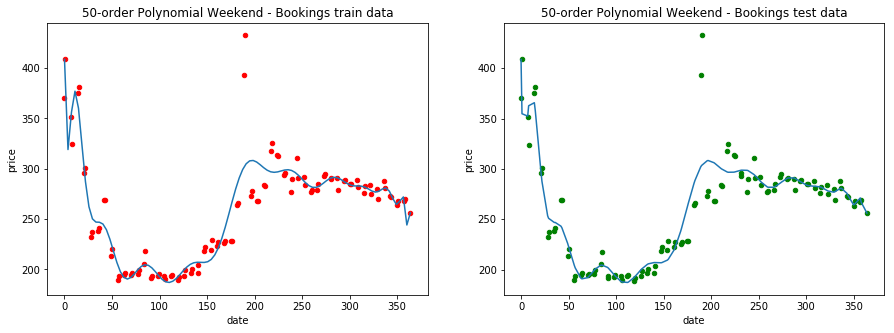

In [41]:
for order in [5, 25, 50]:
    fit_polynomial(order, df_train_summary_weekend, df_test_summary_weekend, title='{}-order Polynomial Weekend'.format(order))

As shown below, the models yield better R2 scores when considering weekdays and weekends separately. Smoothing splines remain however unbeaten.

In [42]:
df_r2_scores

,R2
5-order Polynomial,0.685017
25-order Polynomial,0.725618
50-order Polynomial,0.740342
"Cubic B-spline, knots at quartiles",0.731221
"Cubic B-spline, knots manually chosen",0.747074
Cubic Natural-spline with degree of freedom via CV,0.697682
Smoothing spline,0.909337
5-order Polynomial Weekdays,0.709991
25-order Polynomial Weekdays,0.746212
50-order Polynomial Weekdays,0.759428


### Part 1c: Going the Distance

We may have noticed from the scatterplots of average price versus day on the training set that there are a few days with abnormally high average prices.

Sort the training data in decreasing order of average price, extracting the 3 most expensive dates. Given what we know about Boston, how might we explain why these 3 days happen to be so expensive?

In [43]:
df_train_2.groupby(['date']) \
                    .agg({'price': np.mean}).reset_index() \
                    .sort_values(by=['price'], ascending=False) \
                    .head(3)

,date,price
190,2018-04-14,432.680761
192,2018-04-16,425.289528
191,2018-04-15,417.170404


In [44]:
df_test_2.groupby(['date']) \
                    .agg({'price': np.mean}).reset_index() \
                    .sort_values(by=['price'], ascending=False) \
                    .head(3)

,date,price
191,2018-04-15,470.674107
192,2018-04-16,434.401914
190,2018-04-14,417.286344


On Sunday, April 15, 2018, Boston marks 5 years since marathon attack with tributes. This might explained why demand for Airbnb was the highest Sat, Fri, Mo that weekend.

### Part 2: Predicting Airbnb Rental Price Through Listing Features

In this part, we'll continue our exploration of Airbnb data by predicting price based on listing features. The data can be found in `listings_train.csv` and `listings_test.csv`.

First, visualize the relationship between each of the predictors and the response variable. Does it appear that some of the predictors have a nonlinear relationship with the response variable?

In [45]:
df_listings_train = pd.read_csv('data/listings_train.csv')
df_listings_test = pd.read_csv('data/listings_test.csv')

In [46]:
df_listings_train.head()

,host_total_listings_count,room_type,latitude,longitude,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,availability_365,number_of_reviews
0,1,Private room,42.347956,-71.155196,1.0,1,1,52,1,65,365,26
1,85,Entire home/apt,42.349299,-71.083470,1.0,0,1,110,1,104,107,38
2,6,Entire home/apt,42.341902,-71.073792,1.0,1,1,67,45,56,322,9
3,1,Entire home/apt,42.319235,-71.105016,2.0,2,2,103,8,113,341,49
4,1,Entire home/apt,42.346452,-71.134896,1.0,0,1,8,24,82,41,13


We turn the room type into dummy variables.

In [47]:
df_listings_train.room_type.unique()

array(['Private room', 'Entire home/apt', 'Shared room'], dtype=object)

In [48]:
df_listings_train = pd.get_dummies(df_listings_train, drop_first=True)
df_listings_train.columns = df_listings_train.columns.str.replace(' ', '')
df_listings_test = pd.get_dummies(df_listings_test, drop_first=True)
df_listings_test.columns = df_listings_test.columns.str.replace(' ', '')

In [49]:
df_listings_train.head()

,host_total_listings_count,latitude,longitude,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,availability_365,number_of_reviews,room_type_Privateroom,room_type_Sharedroom
0,1,42.347956,-71.155196,1.0,1,1,52,1,65,365,26,1,0
1,85,42.349299,-71.083470,1.0,0,1,110,1,104,107,38,0,0
2,6,42.341902,-71.073792,1.0,1,1,67,45,56,322,9,0,0
3,1,42.319235,-71.105016,2.0,2,2,103,8,113,341,49,0,0
4,1,42.346452,-71.134896,1.0,0,1,8,24,82,41,13,0,0


We get the features list and plot a scatter plot with the price as response.

In [50]:
features = list(df_listings_train.columns.difference(['price']).values)

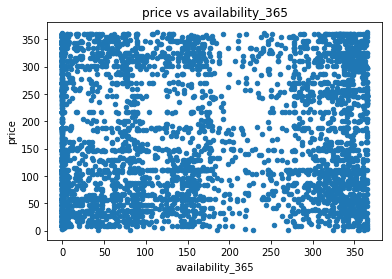

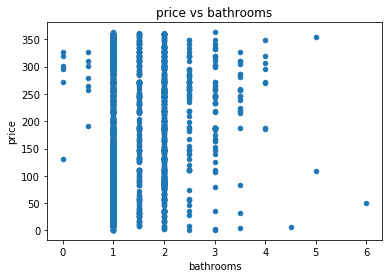

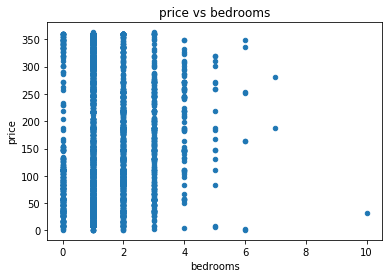

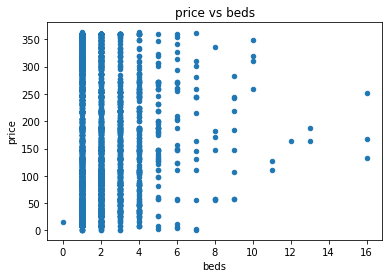

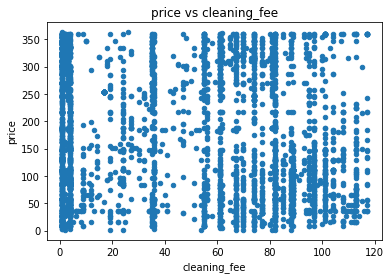

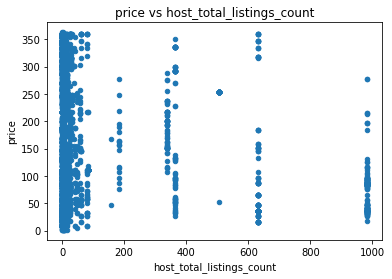

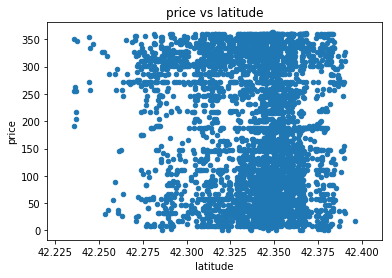

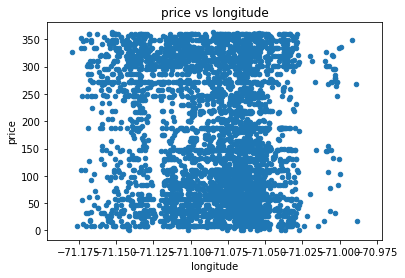

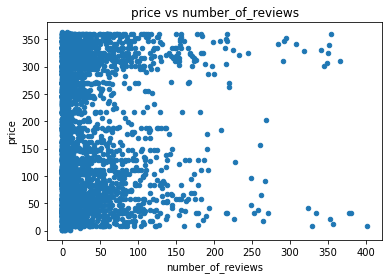

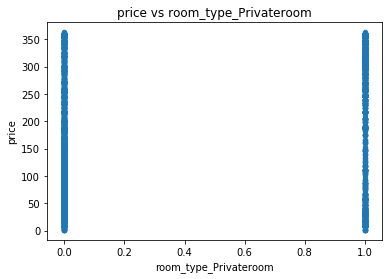

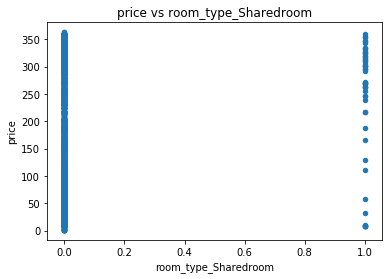

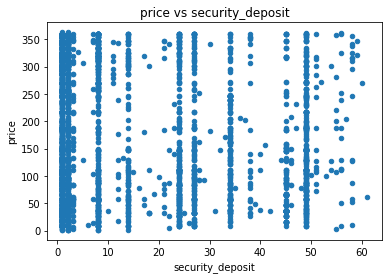

In [51]:
for f in features:
    df_listings_train.sort_values(by=[f]).plot.scatter(x=f, y='price', title='price vs {}'.format(f));

There is no obvious linear trend between any of the features and the price. The scatterplots above depict a nonlinear relationships (curves) between the price and at least the following features:

- `availability_365` 
- `cleaning_fee`
- `number_of_reviews` 

Curves relationships between features and price are not obvious. 

### Part 2a: Polynomial Regression

Fit the following models on the training set and compare the $R^2$ score of the fitted models on the test set:
    
* Linear regression
* Regression with polynomial baseis functions of degree 3 (i.e., basis functions $x$, $x^2$, $x^3$ for each predictor $x$) for quantitative predictors.

In [52]:
# this function generates a R formula object for a given features list
# polynomial terms are included if 'order' has value greater than 1
# raw is set to TRUE to avoid issues with very high polynomial terms
def generate_r_formula(features_list, order):
    if order == 1:
        formula = 'price ~ {}'.format(features_list[0])      
        for f in features_list[1:]:
            formula += ' + {}'.format(f)
    else:
        formula = 'price ~ poly({}, {}, raw=TRUE)'.format(features_list[0], order)
        for f in features_list[1:]:
            formula += ' + ' + 'poly({}, {}, raw=TRUE)'.format(f, order)
    return robjects.Formula(formula)

In [53]:
# this function generates a R data frame containing using the features list provided as parameter, 
# values are taken from the pandas dataframe df
# a 'price' column is added to the dataframe if response=True
def generate_r_dataframe(df, features, response=True):
    if response:
        d = {'price': robjects.FloatVector(df.price)}
    else:
        d = {}
    for f in features:
        d[f] = robjects.FloatVector(df[f])
    return robjects.DataFrame(d)

In [54]:
# this function fits per default a cubic polynomial model and report the R2 on test
# if order=1, a linear regression is fitted instead
def fit_multi_polynomial(order=3, features=features, 
                         df_train=df_listings_train, 
                         df_test=df_listings_test, title='model'):
    
    df_train_r = generate_r_dataframe(df_train, features)
    formula = generate_r_formula(features, order)
    lm = r_lm(formula=formula, data=df_train_r)
    
    df_test_r = generate_r_dataframe(df_test, features, False)
    predictions_test = r_predict(lm, df_test_r)
    
    r2 = r2_score(df_test.price, predictions_test)
    print(title)    
    print("R2 on test: {}".format(r2))
    df_r2_scores.loc[title] = r2

Let's fit a multivariate linear regression

In [55]:
fit_multi_polynomial(order=1, title='Multivariate Linear Regression')

Multivariate Linear Regression
R2 on test: 0.1847912723112517


Let's fit a multivariate polynomial regression

In [56]:
fit_multi_polynomial(order=3, title='3-order Multivariate Polynomial')

3-order Multivariate Polynomial
R2 on test: 0.23784149282211997


We observe low R2 on test, compared to previous results obtained when using booking date as predictor. We recall that we achieved R2 90% on test using smothing splines. 

Here, however, the relationship between listings features (number of beds, reviews, ...) and price seems to be locally nonlinear, rather than globally polynomial. This would explain why the linear regression and 3-order polynomial models perform poorly. This suggests exploring an additive and smoothing approach.

In [57]:
df_r2_scores

,R2
5-order Polynomial,0.685017
25-order Polynomial,0.725618
50-order Polynomial,0.740342
"Cubic B-spline, knots at quartiles",0.731221
"Cubic B-spline, knots manually chosen",0.747074
Cubic Natural-spline with degree of freedom via CV,0.697682
Smoothing spline,0.909337
5-order Polynomial Weekdays,0.709991
25-order Polynomial Weekdays,0.746212
50-order Polynomial Weekdays,0.759428


### Part 2b: Generalized Additive Model (GAM)

Do we see any advantage in fitting an additive regression model to these data, compared to the above models?

1. Fit a GAM to the training set, and compare the test $R^2$ of the fitted model to the above models. We may use a smoothing spline basis function on each predictor, with the same smoothing parameter for each basis function, tuned using cross-validation on the training set.

2. Plot and examine the smooth of each predictor for the fitted GAM. What are some useful insights conveyed by these plots?


**GAM**

GAM requires each smoothing features to have at least 4 unique values. We will consider only such features.

In [58]:
smoothing_features = []
for f in df_listings_train.columns.difference(['price']):
    if len(df_listings_train[f].unique())>4:
        smoothing_features.append(f)

Now we populate the formula and fit a GAM with family gaussian (default).

GAM does not have cross-validation by default. To simplify things we assume that each smoothing parameter is equal.

In [59]:
formula = 'price ~ s({})'.format(smoothing_features[0])
for f in smoothing_features[1:]:
    formula += ' + s({})'.format(f)
gam_formula = robjects.Formula(formula)
for f in smoothing_features:
    gam_formula.environment[f] = robjects.FloatVector(df_listings_train[[f]].values)
gam_formula.environment['price'] = robjects.FloatVector(df_listings_train[['price']].values)

gam = r_gam(gam_formula, family='gaussian')


Let's view the fitted splines.

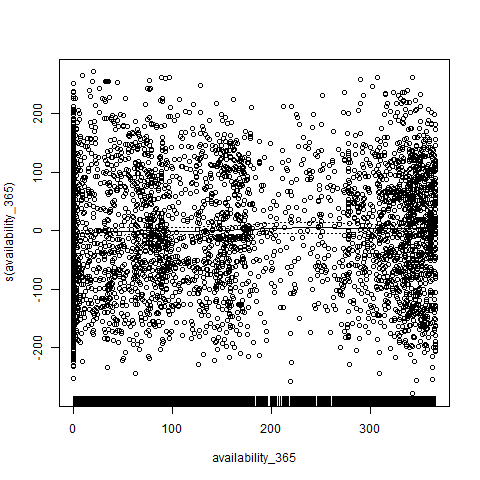

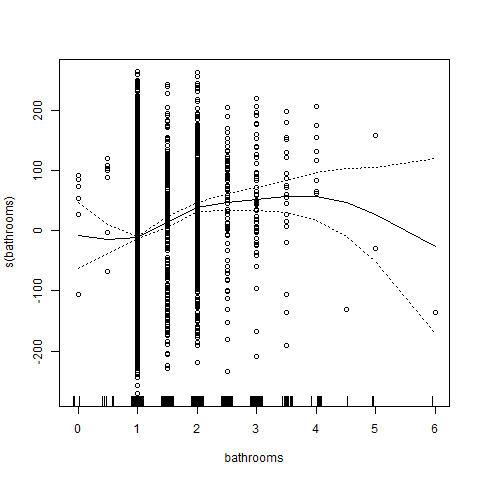

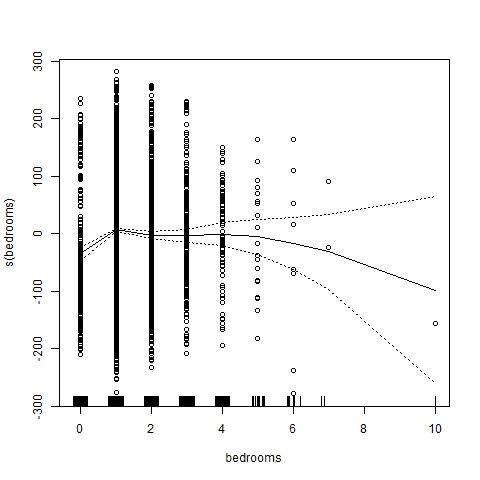

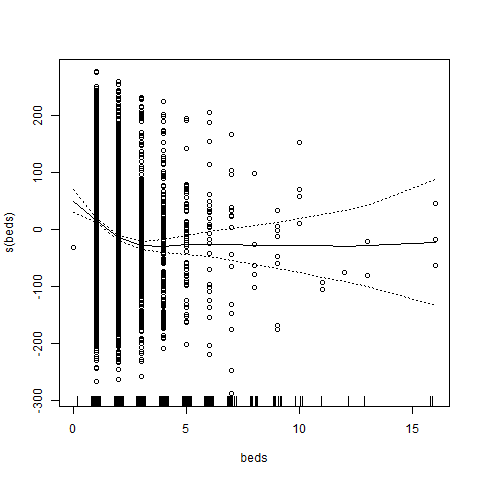

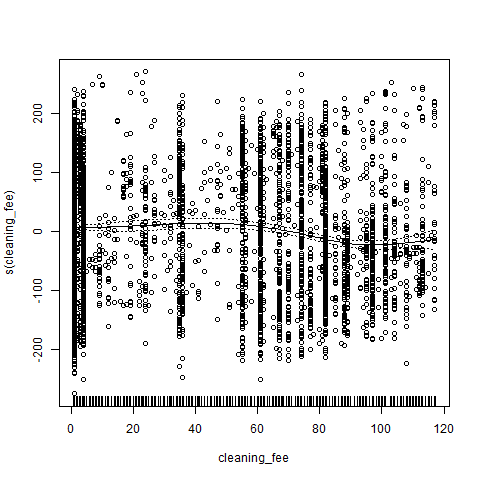

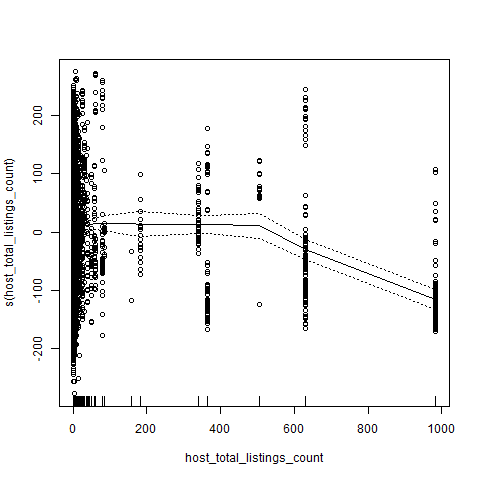

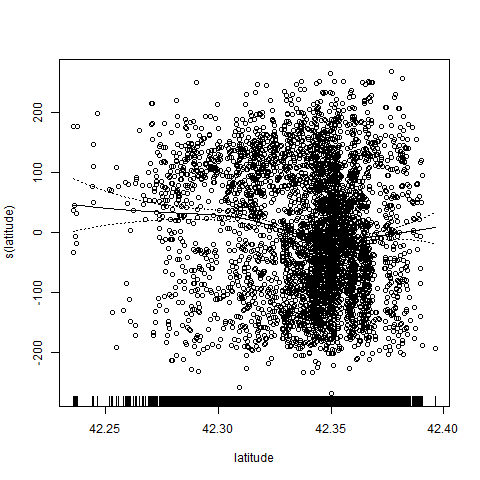

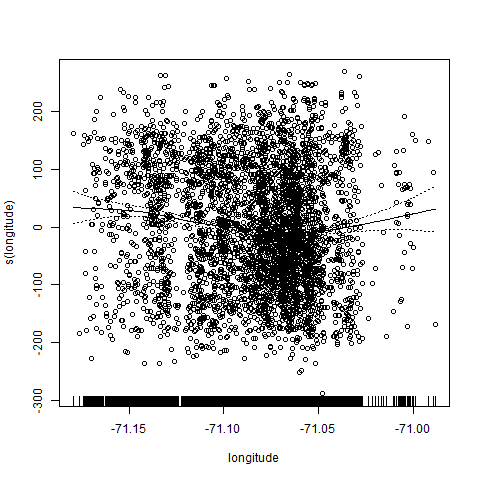

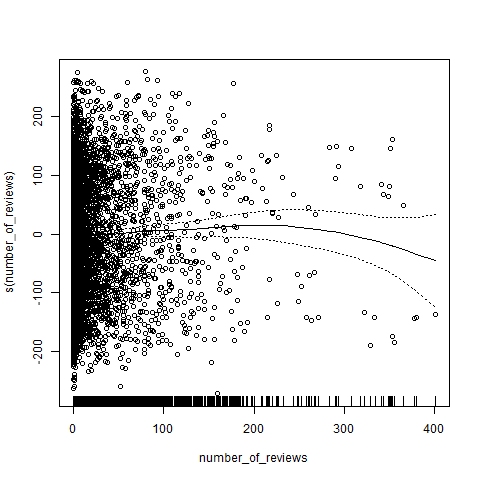

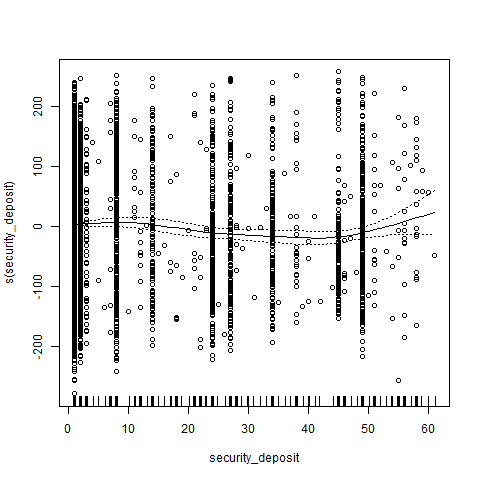

In [60]:
%R -i gam plot(gam, residuals=TRUE,se=TRUE, scale=20);

The GAM smooth lines above allow us to make the following observations:

`availability_365`: the spline is almost a flat line, around zero. The listing availability over the year does not affect the price that much. 

`bathrooms`: listings without bathroom tend to be the cheapest. Price increases with incresing number of bathrooms, up to 4. 

`bedrooms`: listings without bedrooms are the cheapest. Most listings offer 1 bedroom. 2 or more bedrooms tend to reduce the price.

`beds`: price tends to decrease with high number of beds. Usually 1-2 beds are offered.

`cleaning_fee`: listings with very high cleaning fee tend to be cheaper, naturally. 

`host_total_listing_count`: hosts who offer more than 500 listings tend to have lower prices.

`latitude`, `longitude`: listings around lat 42.35 long -71.07 are the cheapest. Listings located around lat 42.25 long -71.17 are more expensive.

`number_of_reviews`: listings with a very large number of reviews tend to be cheaper.

`security_deposit`: listings with security deposit tend to be cheaper.



We can now predict on test. Predict will report the sum of the individual variable effects.

In [61]:
df_listings_test_r = generate_r_dataframe(df_listings_test, smoothing_features, False)
predictions_listings_test = r_predict(gam, df_listings_test_r)
r2 = r2_score(df_listings_test.price, predictions_listings_test)
df_r2_scores.loc['GAM'] = r2
df_r2_scores

,R2
5-order Polynomial,0.685017
25-order Polynomial,0.725618
50-order Polynomial,0.740342
"Cubic B-spline, knots at quartiles",0.731221
"Cubic B-spline, knots manually chosen",0.747074
Cubic Natural-spline with degree of freedom via CV,0.697682
Smoothing spline,0.909337
5-order Polynomial Weekdays,0.709991
25-order Polynomial Weekdays,0.746212
50-order Polynomial Weekdays,0.759428


The R2 obtained on test dataset with GAM is lower than the score we had with multivariate polynomial and linear regression. In order to draw light into this result, we will now have a look at the individual contributions of each smoothing variable to the response.

**Smoothing splines**

We use cross-validation to find a cubic spline smoother for each feature. Each such smoother will minimize the residuals while applying a penalty on oscillations (variations).

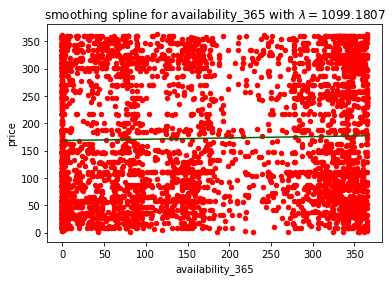

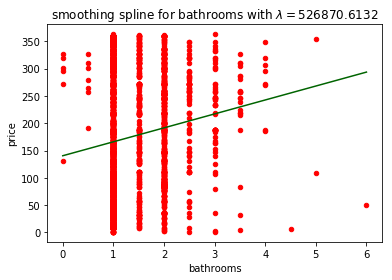

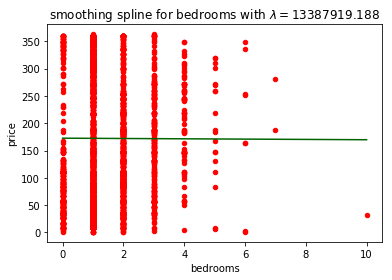

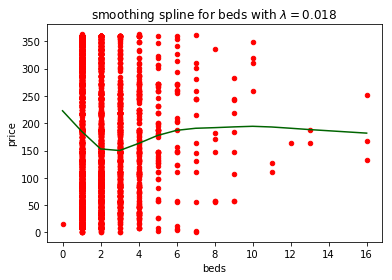

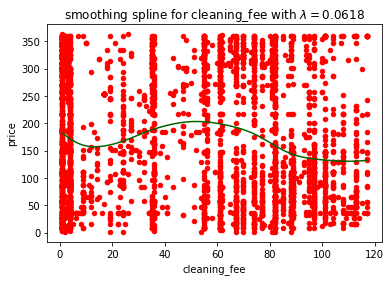

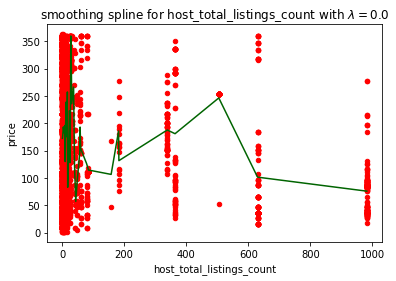

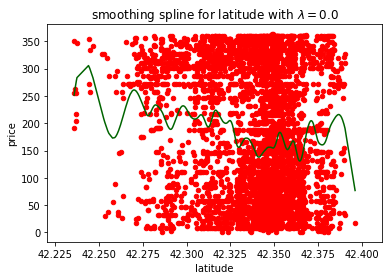

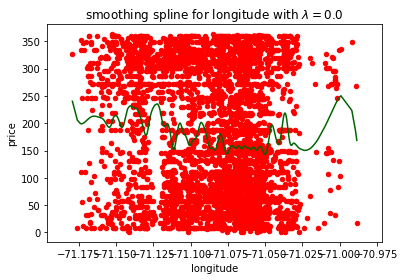

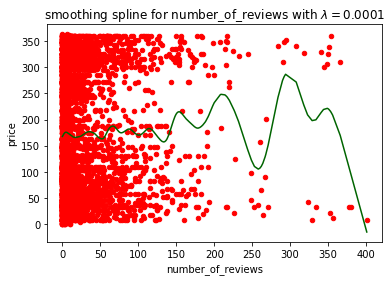

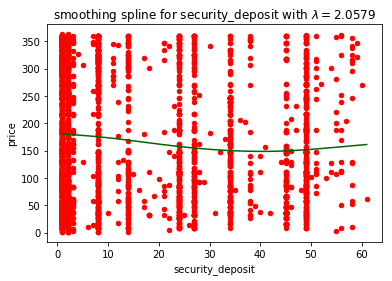

In [62]:
r_price = robjects.FloatVector(df_listings_train.price.values)
for f in smoothing_features: 
    
    r_f = robjects.FloatVector(df_listings_train[f].values)
    spline_cv = r_smooth_spline(x=r_f, y=r_price, cv=True, tol=1/1000000)
    
    lambda_cv = spline_cv.rx2("lambda")[0]
    ax = df_listings_train.plot.scatter(x=f,y='price',c='Red',title="smoothing spline for {} with $\lambda=${}".format(f,str(np.round(lambda_cv,4))))
    ax.set_xlabel(f)
    ax.set_ylabel("price")
    ax.plot(spline_cv.rx2("x"),spline_cv.rx2("y"),color="darkgreen");
    

The plots above suggest that smoothing splines seem reasonable for the following features: `beds`, `cleaning_fee`, `security_deposit`.

The contribution of `availability_365`, `bathrooms` and `bedrooms` to the price appear to follow a linear trend. This is because their smoothers were strongly penalized (high lambda).

The effect of `host_total_listings_count` and `number_of_reviews` are strongly affected by outliers (few listings with very high host/reviews count). We might think of considering these outliers separately.

No CV penalty could be found for `longitude` and `latitude`. The corresponding smoothing splines have higher variation. 

`security_deposit` shows a decreasing trend.

### Part 2c: Putting it All Together

Based on the analysis for problems 1 and 2, what advice would we give a frugal visitor to Boston looking to save some money on an Airbnb rental?



- Visit Boston shortly after Christmas, avoid summer
- Visit Boston during the week, avoid weekends
- Choose listings with high count of reviews from owners who have a large number of listings located around lat 42.35 long -71.07